<a href="https://colab.research.google.com/github/Preyansh17/Pytorch/blob/master/Classification_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits to @knighterudite https://github.com/knighterudite/ML101/blob/master/dnn_classification.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                   skiprows=1)
df = df.drop(columns=["SEX","ID"])
df.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


We import that dataset which is info about credit card clients and whether they defaulted next month.

In [3]:
df.isnull().sum()

LIMIT_BAL                     0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

No missing values

In [4]:
X = df.iloc[:,0:-1]
Y = df.iloc[:,-1]

X = (X - X.min())/(X.max()-X.min()) #Normalisation

X.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,0.0,0.149982,0.069164,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,0.4,0.148892,0.067858,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284


In [5]:
X_part, X_test, Y_part, Y_test = train_test_split(X, Y, test_size=0.2, random_state=8)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_part, Y_part, test_size=0.25, random_state=88)

print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape, Y_test.shape)

(18000, 22) (18000,)
(6000, 22) (6000,)
(6000, 22) (6000,)


In [6]:
X_dev_torch = (torch.Tensor(X_dev.values).float())
Y_dev_torch = (torch.Tensor(Y_dev.values))
X_test_torch = (torch.Tensor(X_test.values).float())
Y_test_torch = (torch.Tensor(Y_test.values))

In [15]:
model = nn.Sequential(nn.Linear(X_train.shape[1],100),
                      nn.Sigmoid(),
                      nn.Linear(100,50),
                      nn.Sigmoid(),
                      nn.Linear(50,25),
                      nn.Sigmoid(),
                      nn.Linear(25,2),
                      )
model

Sequential(
  (0): Linear(in_features=22, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=50, out_features=25, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=25, out_features=2, bias=True)
)

In [27]:
loss_func = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay =0.1)

epochs = 5000
batch_size = 128

In [30]:
train_loss_list, dev_loss_list, train_acc, dev_acc = [],[],[],[]

for i in range(epochs):
  X_train, Y_train = shuffle(X_train, Y_train)
  running_loss = 0
  running_acc = 0
  iter_count = 0

  for j in range(0, len(X_train), batch_size):
    iter_count +=1
    ub = j + batch_size #upper bound
    X_batch = (torch.Tensor(X_train.iloc[j:ub, :].values).float())
    Y_batch = (torch.Tensor(Y_train.iloc[j:ub].values))

    pred = model(X_batch)
    loss = loss_func(pred, Y_batch.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    ps = torch.exp(pred)
    top_p, top_class = ps.topk(1, dim=1)
    running_acc += accuracy_score(Y_batch.long(), top_class)
  
  dev_loss = 0
  acc = 0
  with torch.no_grad():
    model.eval()
    pred_dev = model(X_dev_torch)
    dev_loss = loss_func(pred_dev, Y_dev_torch.long())

    ps_dev = torch.exp(pred_dev)
    top_p, top_class_dev = ps_dev.topk(1, dim=1)
    acc = accuracy_score(Y_dev_torch, top_class_dev)
  
  model.train()

  train_loss_list.append(running_loss/iter_count)
  dev_loss_list.append(dev_loss)
  train_acc.append(running_acc/iter_count)
  dev_acc.append(acc)

  if (i+1)%100 == 0:
    print("Epoch: {}/{}".format(i+1, epochs))
    print("Training Loss: {:.3f}".format(running_loss/iter_count))
    print("Validation Loss: {:.3f}".format(dev_loss))
    print("Training Accuracy: {:.3f}".format(running_acc/iter_count))
    print("Validation Accuracy: {:.3f}\n".format(acc))


Epoch: 100/5000
Training Loss: -259.013
Validation Loss: -259.043
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 200/5000
Training Loss: -258.968
Validation Loss: -259.006
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 300/5000
Training Loss: -258.972
Validation Loss: -259.007
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 400/5000
Training Loss: -258.970
Validation Loss: -258.976
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 500/5000
Training Loss: -258.973
Validation Loss: -258.982
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 600/5000
Training Loss: -258.968
Validation Loss: -259.007
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 700/5000
Training Loss: -258.962
Validation Loss: -258.996
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 800/5000
Training Loss: -258.965
Validation Loss: -258.975
Training Accuracy: 0.777
Validation Accuracy: 0.784

Epoch: 900/5000
Training Loss: -258.974
Validati

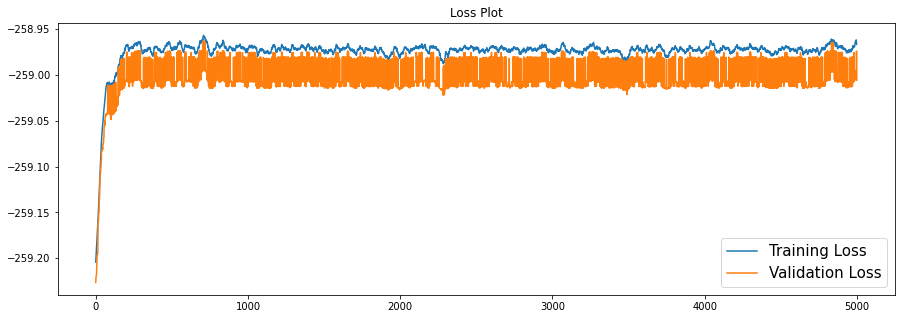

In [31]:
fig = plt.figure(figsize=(15,5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(dev_loss_list, label='Validation Loss')
plt.legend(loc='best',fontsize=15)
plt.title("Loss Plot")
plt.show()

In [32]:
model.eval()
test_pred = model(X_test_torch)
test_pred = torch.exp(test_pred)
top_p, top_class_test = test_pred.topk(1, dim=1)
acc_test = accuracy_score(Y_test_torch, top_class_test)
print("Test Accuracy: {:.3f}%".format(100*acc_test))

model.train()

Test Accuracy: 77.867%


Sequential(
  (0): Linear(in_features=22, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=50, out_features=25, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=25, out_features=2, bias=True)
)